## Trajectory Prediction by Interpolation

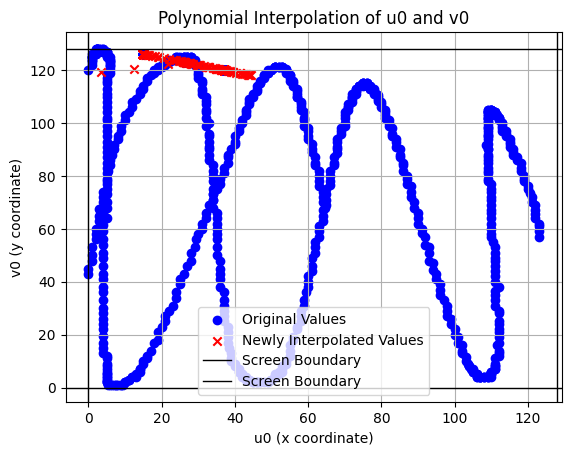

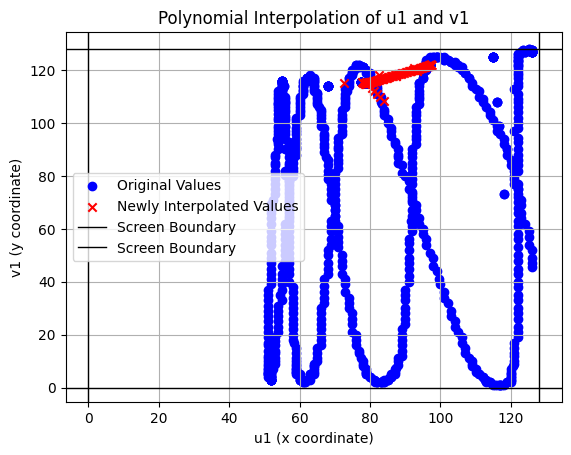

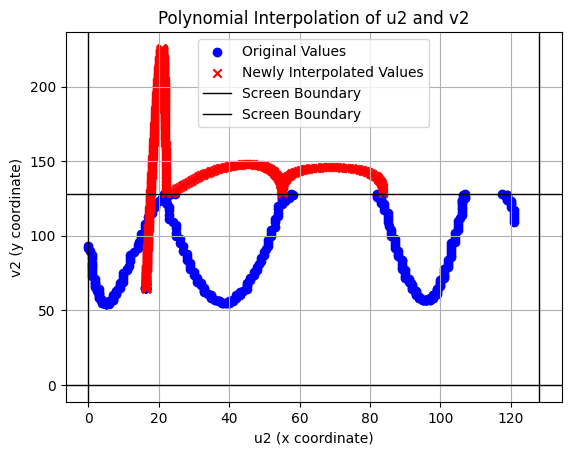

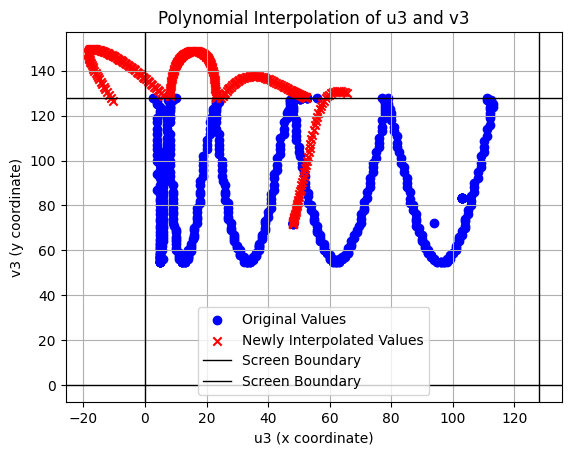

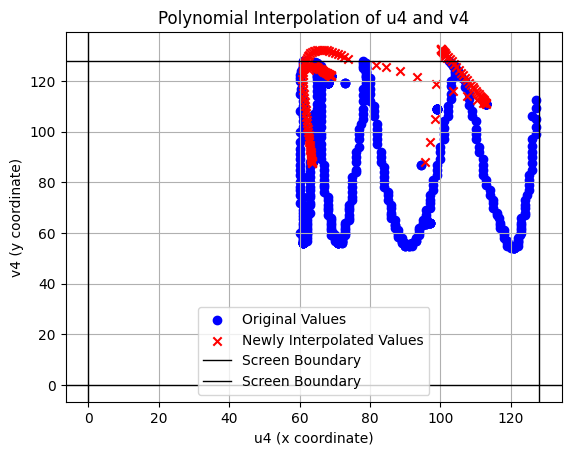

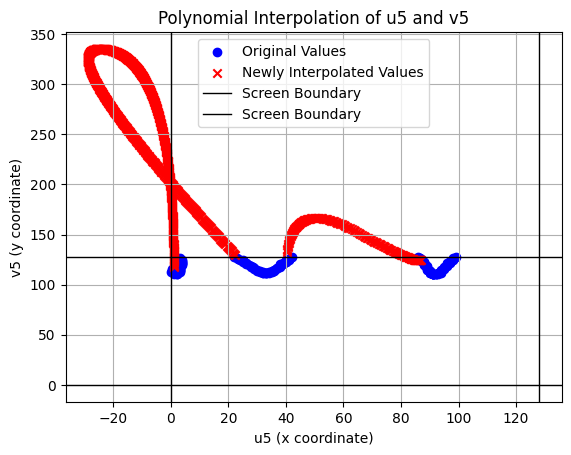

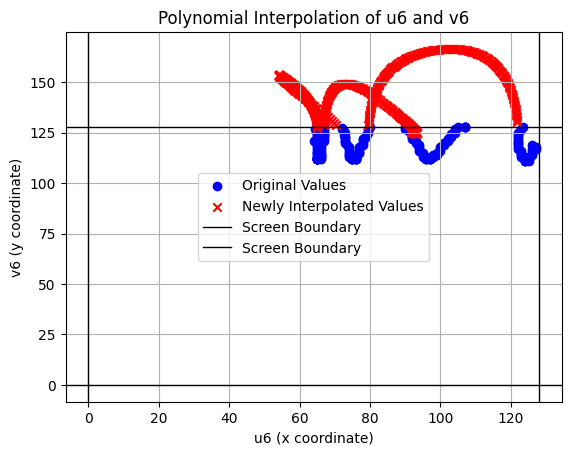

In [361]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.impute import KNNImputer
from matplotlib import pyplot as plt

# Load the data
red_ball_fill = pd.read_csv('../test-data/red_ball_coordinates_128px_2024-02-27_15h51m.csv', delimiter=',', decimal='.')

# Number of cameras
num_cameras = 7
result_df = red_ball_fill.copy()

# Loop through each pair of 'u' and 'v'
for i in range(num_cameras):
    col_u = f'u{i}'
    col_v = f'v{i}'

    # Extract the columns 'u' and 'v' for the current pair
    X_0 = red_ball_fill[[col_u, col_v]]

    # Create a copy to keep non-NaN rows
    X_0_copy = X_0.copy()

    X_0_nan = X_0_copy[X_0_copy.isna().any(axis=1)]

    # Drop NaN rows for z-score calculation
    X_0_non_nan = X_0.dropna()

    # Apply Isolation Forest to detect outliers
    model = IsolationForest(contamination=0.2)
    model.fit(X_0_non_nan)
    outliers_mask = model.predict(X_0_non_nan) == -1

    # Drop rows identified as outliers
    for index in X_0_copy.index:
        if index in X_0_non_nan.index[outliers_mask]:
            X_0_copy = X_0_copy.drop(index)

    # Interpolate missing values
    X_0_copy.interpolate(method='polynomial', inplace=True, order=2)

    # Fill NaN values in the original DataFrame with the interpolated values
    X_0_nan = X_0_nan.fillna(X_0_copy)

    # Apply KNNImputer
    imputer = KNNImputer(n_neighbors=5)
    X_0_copy = X_0_copy.to_numpy()
    X_0_copy = imputer.fit_transform(X_0_copy)

    # Convert X_0_copy back to a DataFrame
    X_0_copy = pd.DataFrame(X_0_copy, columns=[col_u, col_v])

    # Find the indices of NaN rows in the original DataFrame red_ball_fill
    nan_indices = X_0_nan.index
    result_df.loc[nan_indices, [col_u, col_v]] = X_0_copy[[col_u, col_v]]
    # Replace the corresponding rows in red_ball_fill with the imputed values from X_0_copy
    red_ball_fill.loc[nan_indices, [col_u, col_v]] = X_0_copy[[col_u, col_v]]

    # Plot the results for the current pair
    plt.scatter(X_0[col_u], X_0[col_v], c='blue', marker='o', label='Original Values')
    plt.scatter(X_0_nan[col_u], X_0_nan[col_v], c='red', marker='x', label='Newly Interpolated Values')

    # Add lines to represent the screen boundaries
    plt.axvline(x=128, color='black', linewidth=1, label='Screen Boundary')
    plt.axhline(y=128, color='black', linewidth=1)
    plt.axvline(x=0, color='black', linewidth=1, label='Screen Boundary')
    plt.axhline(y=0, color='black', linewidth=1)

    plt.title(f'Polynomial Interpolation of {col_u} and {col_v}')
    plt.xlabel(f'{col_u} (x coordinate)')
    plt.ylabel(f'{col_v} (y coordinate)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [362]:
result_df.isna().sum()

u0      0
v0      0
u1     27
v1     27
u2     50
v2     50
u3    115
v3    115
u4    111
v4    111
u5     27
v5     27
u6     38
v6     38
dtype: int64

In [363]:
# store the df in a csv file in the dir ../interpolated-data
result_df.to_csv('../interpolated-data/red_ball_coordinates_128px_2024-02-27_15h51m_interpolated.csv', index=False)